In [19]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import os

In [20]:
carpeta_so2 = "Datasets\Datos_SIATA_Aire_so2.json"

with open(carpeta_so2, "r", encoding="utf-8") as f:data = json.load(f)

registros = []

        
for estacion in data:
    lat = estacion.get("latitud")
    lon = estacion.get("longitud")
    codigo = estacion.get("codigoSerial")
    nombre = estacion.get("nombre")
    nombreCorto = estacion.get("nombreCorto")
    datos = estacion.get("datos", [])

    for entrada in datos:
        registros.append({
            "codigoSerial": codigo,
            "nombreCorto": nombreCorto,
            "nombre": nombre,
            "latitud": lat,
            "longitud": lon,
            "contaminante": entrada.get("variableConsulta"),
            "fecha": entrada.get("fecha"),
            "calibracion": entrada.get("valor"), # Ojooo esto es calibración 
            "valor": entrada.get("calidad") # Y esto calidad, osea que la calidad se llama valor y la calibración valga la redundancia calibración 
        })

# Convertimos a DataFrame como antes
df = pd.DataFrame(registros)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
df["calibracion"] = pd.to_numeric(df["calibracion"], errors='coerce')


df.loc[df["calibracion"] == -9999, 'valor'] = np.nan

print(df.tail(20))

      codigoSerial nombreCorto                               nombre   latitud  \
8741             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8742             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8743             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8744             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8745             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8746             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8747             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8748             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8749             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8750             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8751             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8752             3    GIR-SO

In [21]:
validos_por_estacion = df.groupby('nombreCorto')['valor'].apply(lambda x: x.notna().mean() * 100)
validos_por_contaminante = df.groupby('contaminante')['valor'].apply(lambda x: x.notna().mean() * 100)
print(f"Porcentaje datos válidos por estación\n{validos_por_estacion}\n\nPorcentaje datos válidos por contaminante{validos_por_contaminante}")

Porcentaje datos válidos por estación
nombreCorto
GIR-SOSN    0.045657
Name: valor, dtype: float64

Porcentaje datos válidos por contaminantecontaminante
so2    0.045657
Name: valor, dtype: float64


In [22]:
# Obtener contaminante único (ya que el archivo es solo de uno)
contaminante_unico = df['contaminante'].unique()[0] if not df['contaminante'].isna().all() else "Desconocido"


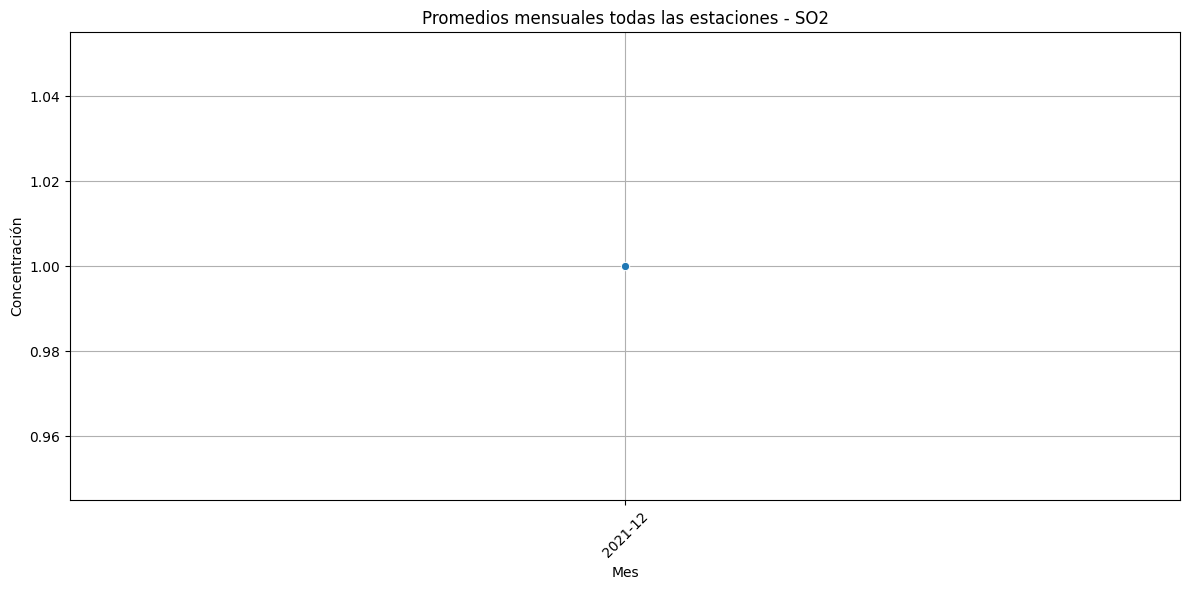

In [23]:
df['mes'] = df['fecha'].dt.to_period("M")
promedios_mensuales = df.groupby('mes')['valor'].mean().reset_index()
promedios_mensuales['mes'] = promedios_mensuales['mes'].astype(str)

# Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=promedios_mensuales, x='mes', y='valor', marker='o')
plt.title(f'Promedios mensuales todas las estaciones - {contaminante_unico.upper()}')
plt.xlabel('Mes')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# 5. Mapa estático de estaciones segun datos validos



# Media por estacion
media_estaciones = df.groupby(['codigoSerial', 'nombre', 'latitud', 'longitud'])['valor'].mean().reset_index()

validos_por_estacion = df.groupby('codigoSerial')['valor'].apply(lambda x: x.notna().mean() * 100)

media_estaciones['porcentaje_validos'] = media_estaciones['codigoSerial'].map(validos_por_estacion)


mapa = folium.Map(location=[6.25, -75.6], zoom_start=11)

for _, row in media_estaciones.iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=6,
        popup=(
            f"Estación {row['nombre']}\n"
            f"Media: {row['valor']:.2f}\n"
            f"Válidos: {row['porcentaje_validos']:.1f}%"
        ),
        color = 'green' if row['porcentaje_validos'] >= 51 else 'red',
        fill=True,
    ).add_to(mapa)

mapa

In [25]:
# mapa por estacion según concentracion de la partícula


# Media por estación
media_estaciones = df.groupby(['codigoSerial', 'nombre', 'latitud', 'longitud'])['valor'].mean().reset_index()

# Porcentaje de datos válidos por estación
validos_por_estacion = df.groupby('codigoSerial')['valor'].apply(lambda x: x.notna().mean() * 100)
media_estaciones['porcentaje_validos'] = media_estaciones['codigoSerial'].map(validos_por_estacion)

# Clasificación de color según niveles de concentración promedio
def clasificar_calidad_aire(valor, contaminante):
    if pd.isna(valor):
        return "Sin datos"
    
    contaminante = contaminante.lower()
    
    if contaminante == 'pm25':
        if valor <= 12:
            return "Bueno"
        elif valor <= 35.4:
            return "Aceptable"
        elif valor <= 55.4:
            return "No saludable sensibles"
        elif valor <= 150.4:
            return "No saludable"
        elif valor <= 250.4:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'pm10':
        if valor <= 54:
            return "Bueno"
        elif valor <= 154:
            return "Aceptable"
        elif valor <= 254:
            return "No saludable sensibles"
        elif valor <= 354:
            return "No saludable"
        elif valor <= 424:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'co':
        if valor <= 4.4:
            return "Bueno"
        elif valor <= 9.4:
            return "Aceptable"
        elif valor <= 12.4:
            return "No saludable sensibles"
        elif valor <= 15.4:
            return "No saludable"
        elif valor <= 30.4:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'o3':
        if valor <= 0.054:
            return "Bueno"
        elif valor <= 0.070:
            return "Aceptable"
        elif valor <= 0.085:
            return "No saludable sensibles"
        elif valor <= 0.105:
            return "No saludable"
        elif valor <= 0.200:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'no2':
        if valor <= 0.053:
            return "Bueno"
        elif valor <= 0.100:
            return "Aceptable"
        elif valor <= 0.360:
            return "No saludable sensibles"
        elif valor <= 0.649:
            return "No saludable"
        elif valor <= 1.249:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'so2':
        if valor <= 0.035:
            return "Bueno"
        elif valor <= 0.075:
            return "Aceptable"
        elif valor <= 0.185:
            return "No saludable sensibles"
        elif valor <= 0.304:
            return "No saludable"
        elif valor <= 0.604:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'no' or contaminante == 'pm1':
        return "Sin estándar oficial"

    else:
        return "Contaminante desconocido"
    
def color_por_categoria(categoria):
    colores = {
        "Bueno": "green",
        "Aceptable": "yellow",
        "No saludable sensibles": "orange",
        "No saludable": "red",
        "Muy no saludable": "purple",
        "Peligroso": "maroon",
        "Sin datos": "gray",
        "Sin estándar oficial": "blue",
        "Contaminante desconocido": "black"
    }
    return colores.get(categoria, "black")


# Crear mapa
mapa = folium.Map(location=[6.25, -75.6], zoom_start=11)

for _, row in media_estaciones.iterrows():
    categoria = clasificar_calidad_aire(row['valor'], contaminante_unico) 
    color = color_por_categoria(categoria)
    radio = 4 + (row['valor'] / 5) if not pd.isna(row['valor']) else 4
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=radio,
        popup=folium.Popup(
            f"<b>{row['nombre']}</b><br>"
            f"Media: {row['valor']:.2f}<br>"
            f"Categoría: {categoria}<br>"
            f"Válidos: {row['porcentaje_validos']:.1f}%",
            max_width=300
        ),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(mapa)

# Mostrar mapa en notebook
mapa

In [26]:
df['categoria_calidad'] = df.apply(
    lambda row: clasificar_calidad_aire(row['valor'], row['contaminante']),
    axis=1
)
df

,codigoSerial,nombreCorto,nombre,latitud,longitud,contaminante,fecha,calibracion,valor,mes,categoria_calidad
0,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2021-12-14 04:00:00,-9999.0,NaN,2021-12,Sin datos
1,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2021-12-14 05:00:00,-9999.0,NaN,2021-12,Sin datos
2,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2021-12-14 06:00:00,-9999.0,NaN,2021-12,Sin datos
3,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2021-12-14 07:00:00,-9999.0,NaN,2021-12,Sin datos
4,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2021-12-14 08:00:00,-9999.0,NaN,2021-12,Sin datos
...,...,...,...,...,...,...,...,...,...,...,...
8756,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2022-12-14 00:00:00,-9999.0,NaN,2022-12,Sin datos
8757,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2022-12-14 01:00:00,-9999.0,NaN,2022-12,Sin datos
8758,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2022-12-14 02:00:00,-9999.0,NaN,2022-12,Sin datos
8759,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2022-12-14 03:00:00,-9999.0,NaN,2022-12,Sin datos


In [27]:
df['dia_semana'] = df['fecha'].dt.weekday  # Lunes=0, Domingo=6
df['es_fin_semana'] = df['dia_semana'] >= 5

In [28]:
eventos_especiales = {
    '2021-12-24': 'Navidad',
    '2021-12-31': 'Año Nuevo',
    '2022-01-06': 'Día de Reyes',
    '2022-04-10': 'Semana Santa',
    '2022-04-15': 'Semana Santa',
    '2022-07-20': 'Independencia',
    '2022-08-07': 'Feria de las Flores',
    '2022-08-08': 'Feria de las Flores',
    '2022-09-22': 'Día sin carro',
    '2022-10-31': 'Halloween',
    '2022-12-07': 'Día de las Velitas',
    '2022-12-24': 'Navidad',
    '2022-12-31': 'Año Nuevo',
    # Puedes seguir agregando...
}


In [29]:
df['fecha_str'] = df['fecha'].dt.strftime('%Y-%m-%d')
df['evento'] = df['fecha_str'].map(eventos_especiales).fillna("Normal")
df

,codigoSerial,nombreCorto,nombre,latitud,longitud,contaminante,fecha,calibracion,valor,mes,categoria_calidad,dia_semana,es_fin_semana,fecha_str,evento
0,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2021-12-14 04:00:00,-9999.0,NaN,2021-12,Sin datos,1,False,2021-12-14,Normal
1,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2021-12-14 05:00:00,-9999.0,NaN,2021-12,Sin datos,1,False,2021-12-14,Normal
2,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2021-12-14 06:00:00,-9999.0,NaN,2021-12,Sin datos,1,False,2021-12-14,Normal
3,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2021-12-14 07:00:00,-9999.0,NaN,2021-12,Sin datos,1,False,2021-12-14,Normal
4,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2021-12-14 08:00:00,-9999.0,NaN,2021-12,Sin datos,1,False,2021-12-14,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2022-12-14 00:00:00,-9999.0,NaN,2022-12,Sin datos,2,False,2022-12-14,Normal
8757,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2022-12-14 01:00:00,-9999.0,NaN,2022-12,Sin datos,2,False,2022-12-14,Normal
8758,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2022-12-14 02:00:00,-9999.0,NaN,2022-12,Sin datos,2,False,2022-12-14,Normal
8759,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,so2,2022-12-14 03:00:00,-9999.0,NaN,2022-12,Sin datos,2,False,2022-12-14,Normal


In [30]:
#Semana vs fin de semana

promedios_dia = df.groupby('es_fin_semana')['valor'].mean()
print(promedios_dia)

es_fin_semana
False    NaN
True     1.0
Name: valor, dtype: float64


In [31]:
#fechas especiales vs fechas normales

promedios_evento = df.groupby('evento')['valor'].mean()
print(promedios_evento)

evento
Año Nuevo              NaN
Día de Reyes           NaN
Día de las Velitas     NaN
Día sin carro          NaN
Feria de las Flores    NaN
Halloween              NaN
Independencia          NaN
Navidad                NaN
Normal                 1.0
Semana Santa           NaN
Name: valor, dtype: float64


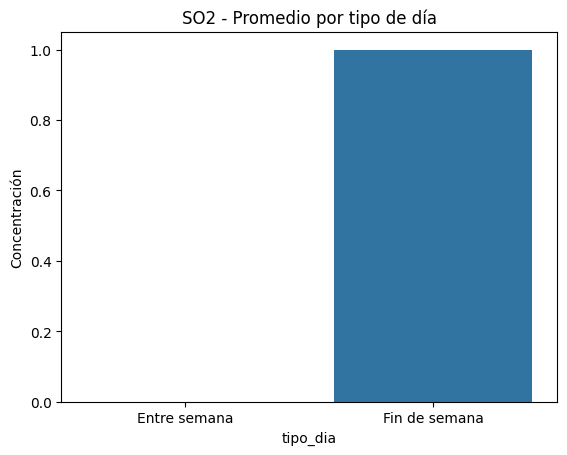

In [32]:
df['dia_semana'] = df['fecha'].dt.weekday
df['tipo_dia'] = df['dia_semana'].apply(lambda x: 'Fin de semana' if x >= 5 else 'Entre semana')

sns.barplot(data=df, x='tipo_dia', y='valor')
plt.title(f'{contaminante_unico.upper()} - Promedio por tipo de día')
plt.ylabel('Concentración')
plt.show()
#Semana vs fin de semana

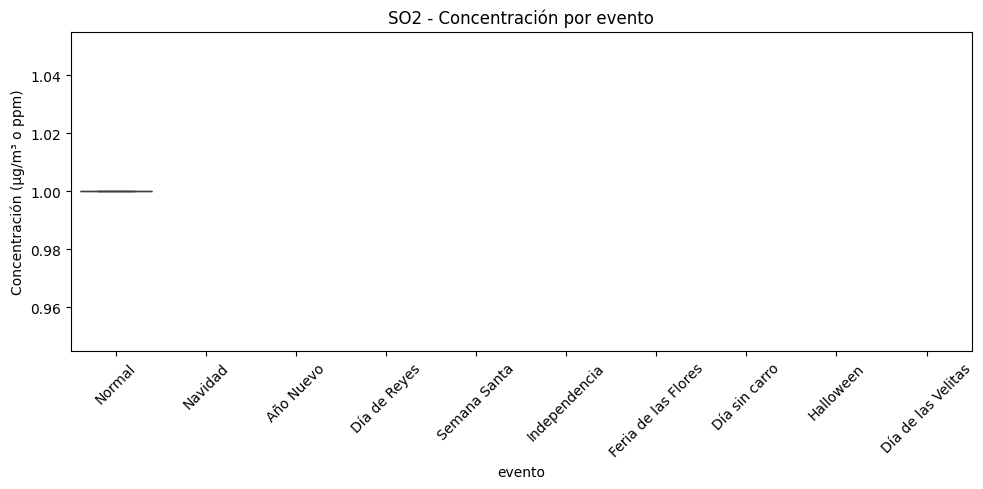

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='evento', y='valor')
plt.title(f'{contaminante_unico.upper()} - Concentración por evento')
plt.ylabel('Concentración (μg/m³ o ppm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#fechas especiales vs fechas normales

In [34]:
resumen = df.groupby(['tipo_dia', 'evento'])['valor'].mean().unstack()
resumen

evento,Año Nuevo,Día de Reyes,Día de las Velitas,Día sin carro,Feria de las Flores,Halloween,Independencia,Navidad,Normal,Semana Santa
tipo_dia,,,,,,,,,,
Entre semana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin de semana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [35]:
#estaciones con peor aire

media_top = media_estaciones[['nombre', 'valor']].sort_values(by='valor', ascending=False)
print(media_top.head(10))

                                nombre  valor
0  _OFF-Girardota - S.O.S Aburrá Norte    1.0


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_21840\2538979619.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=estaciones_ordenadas, x='valor', y='nombre', palette='Spectral')


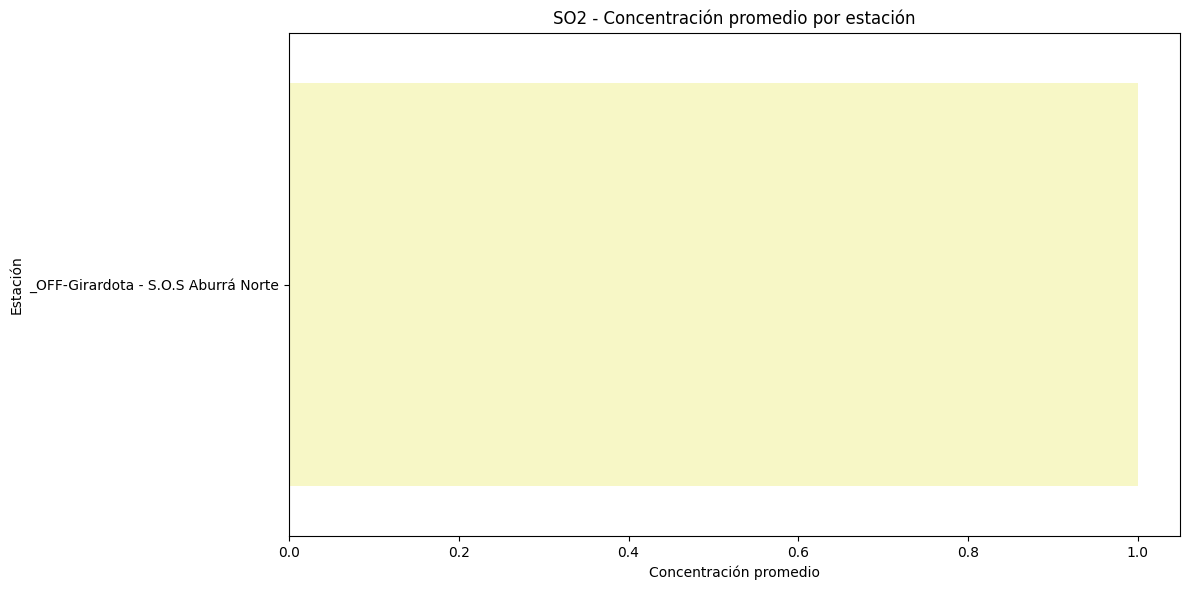

In [36]:
plt.figure(figsize=(12, 6))
estaciones_ordenadas = media_estaciones.sort_values(by='valor', ascending=False)
sns.barplot(data=estaciones_ordenadas, x='valor', y='nombre', palette='Spectral')
plt.title(f'{contaminante_unico.upper()} - Concentración promedio por estación')
plt.xlabel('Concentración promedio')
plt.ylabel('Estación')
plt.tight_layout()
plt.show()

In [37]:
media_plot = media_estaciones.dropna(subset=['valor'])


import plotly.express as px

fig = px.scatter_mapbox(
    media_plot,
    lat="latitud", lon="longitud",
    color="valor",
    size="valor",
    hover_name="nombre",
    color_continuous_scale="YlOrRd",
    size_max=15,
    zoom=10,
    mapbox_style="carto-positron"
)
fig.update_layout(title=f'{contaminante_unico.upper()} - Concentración por estación')
fig.show()

C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_21840\3915280519.py:6: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


In [38]:
limites_normativos = {
    'pm25': 25,   # μg/m³ (24h) - OMS
    'pm10': 50,   # μg/m³ (24h) - OMS
    'ozono': 0.051,  # ppm (8h) - OMS 100 μg/m³ → 0.051 ppm aprox
    'co': 4.0,    # ppm (24h) - OMS
    'no2': 0.025, # ppm (1h) - OMS
    'so2': 0.005, # ppm (24h) - OMS
    # otros...
}

In [39]:
contaminante = contaminante_unico.lower()
limite = limites_normativos.get(contaminante, None)

if limite:
    df['excede_limite'] = df['valor'] > limite
    excedencias = df['excede_limite'].mean() * 100
    print(f"📌 Porcentaje de registros que exceden el límite OMS para {contaminante.upper()}: {excedencias:.2f}%")
else:
    print("No hay límite definido para este contaminante.")

📌 Porcentaje de registros que exceden el límite OMS para SO2: 0.05%


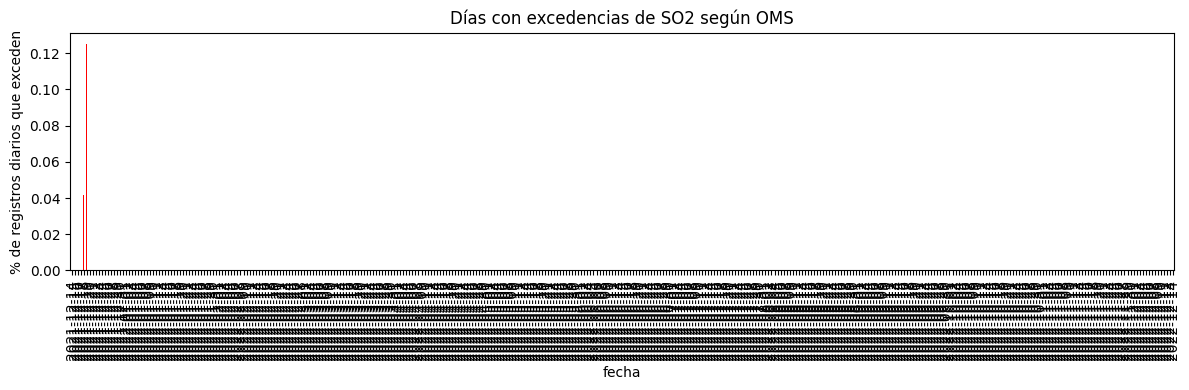

In [40]:
#gafico de dias que exceden

excesos_diarios = df.groupby(df['fecha'].dt.date)['excede_limite'].mean()

plt.figure(figsize=(12, 4))
excesos_diarios.plot(kind='bar', color='red')
plt.title(f'Días con excedencias de {contaminante.upper()} según OMS')
plt.ylabel('% de registros diarios que exceden')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

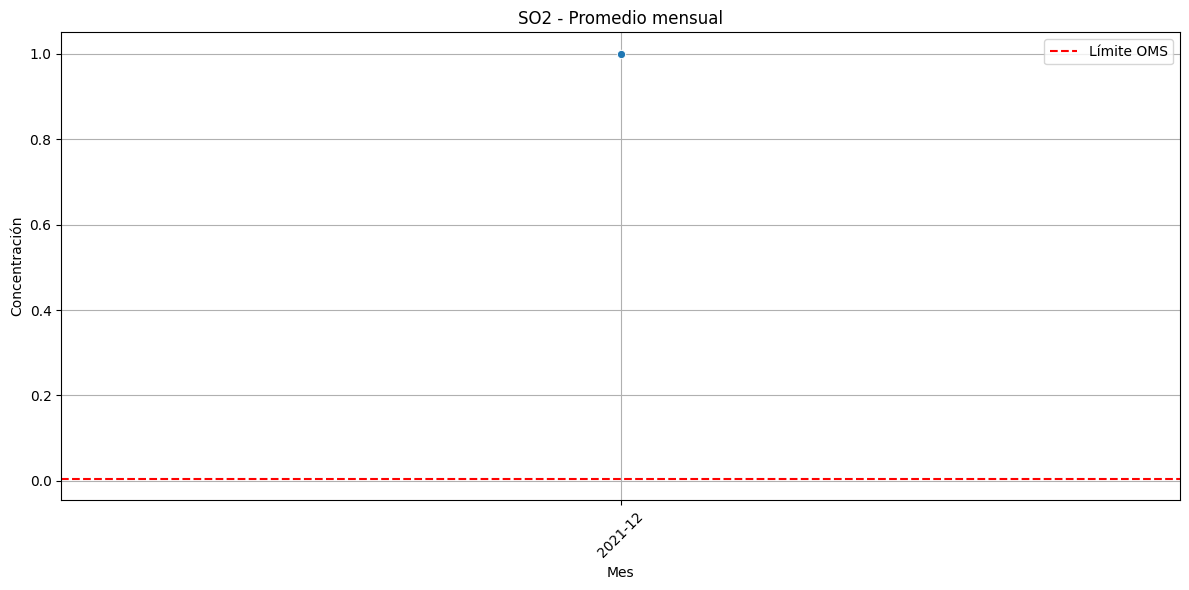

In [41]:
#comparar promedios mensuales con los limites
plt.figure(figsize=(12,6))
sns.lineplot(data=promedios_mensuales, x='mes', y='valor', marker='o')
if limite:
    plt.axhline(y=limite, color='red', linestyle='--', label='Límite OMS')
plt.title(f'{contaminante_unico.upper()} - Promedio mensual')
plt.xlabel('Mes')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

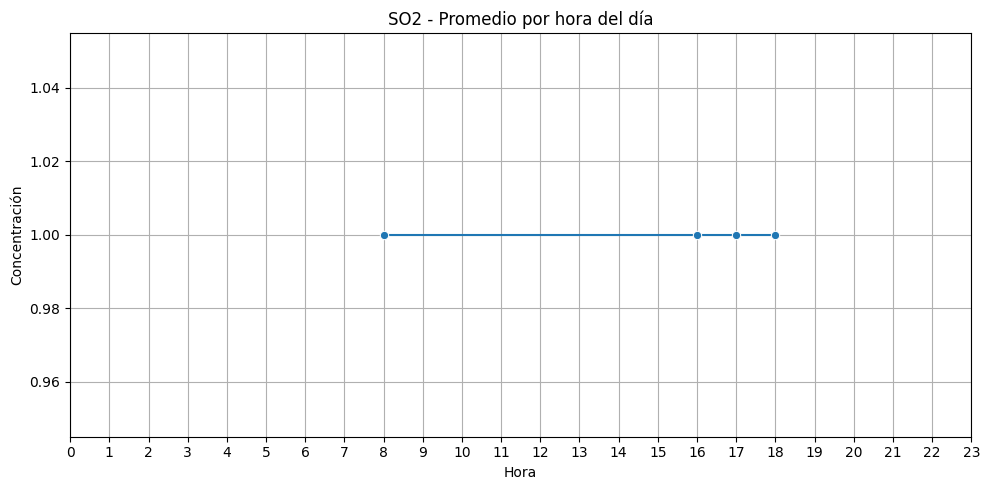

In [42]:
#variacion por hora del dia
df['hora'] = df['fecha'].dt.hour

horas = df.groupby('hora')['valor'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=horas, x='hora', y='valor', marker='o')
plt.title(f'{contaminante_unico.upper()} - Promedio por hora del día')
plt.xlabel('Hora')
plt.ylabel('Concentración')
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
#Top 10 dias mas contaminados
top_dias = df.groupby(df['fecha'].dt.date)['valor'].mean().sort_values(ascending=False).head(10)
print("Días con mayor concentración promedio:")
print(top_dias)

Días con mayor concentración promedio:
fecha
2021-12-18    1.0
2021-12-19    1.0
2021-12-14    NaN
2021-12-15    NaN
2021-12-16    NaN
2021-12-17    NaN
2021-12-20    NaN
2021-12-21    NaN
2021-12-22    NaN
2021-12-23    NaN
Name: valor, dtype: float64


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_21840\975894284.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




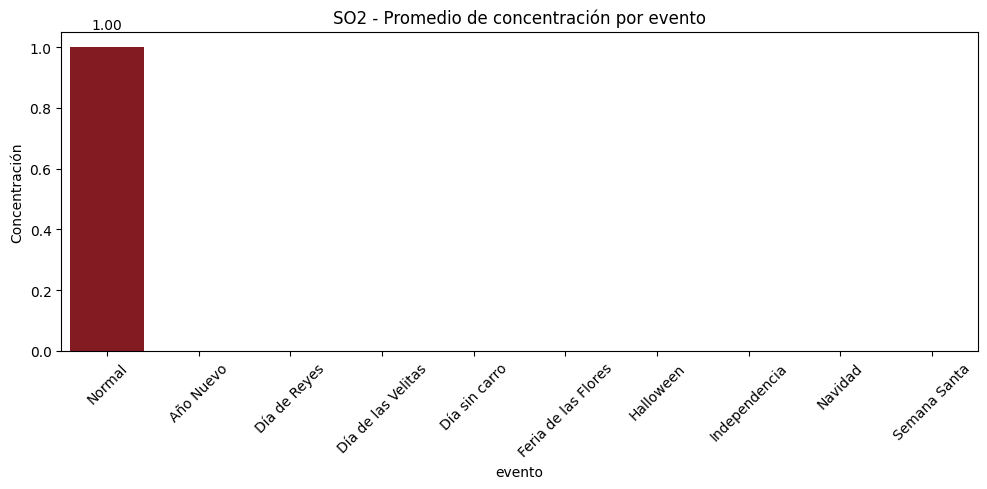

In [44]:
promedio_eventos = df.groupby('evento')['valor'].mean().sort_values(ascending=False)

# Convertir a DataFrame y ordenar por valor (descendente)
evento_df = promedio_eventos.reset_index()
evento_df.columns = ['evento', 'valor']
evento_df = evento_df.sort_values(by='valor', ascending=False).reset_index(drop=True)

# Crear una paleta personalizada basada en el número de eventos
paleta = sns.color_palette("Reds", n_colors=len(evento_df))

# Graficar
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=evento_df,
    x='evento', y='valor',
    palette=paleta[::-1]  
)

# Agregar etiquetas
for i, val in enumerate(evento_df['valor']):
    ax.text(i, val + 0.05, f'{val:.2f}', ha='center', va='bottom')

plt.title(f'{contaminante_unico.upper()} - Promedio de concentración por evento')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
stats_eventos = df.groupby('evento')['valor'].agg(['count', 'mean', 'std', 'min', 'max']).sort_values(by='mean', ascending=False)
print(stats_eventos)

                     count  mean  std  min  max
evento                                         
Normal                   4   1.0  0.0  1.0  1.0
Año Nuevo                0   NaN  NaN  NaN  NaN
Día de Reyes             0   NaN  NaN  NaN  NaN
Día de las Velitas       0   NaN  NaN  NaN  NaN
Día sin carro            0   NaN  NaN  NaN  NaN
Feria de las Flores      0   NaN  NaN  NaN  NaN
Halloween                0   NaN  NaN  NaN  NaN
Independencia            0   NaN  NaN  NaN  NaN
Navidad                  0   NaN  NaN  NaN  NaN
Semana Santa             0   NaN  NaN  NaN  NaN


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_21840\211640032.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




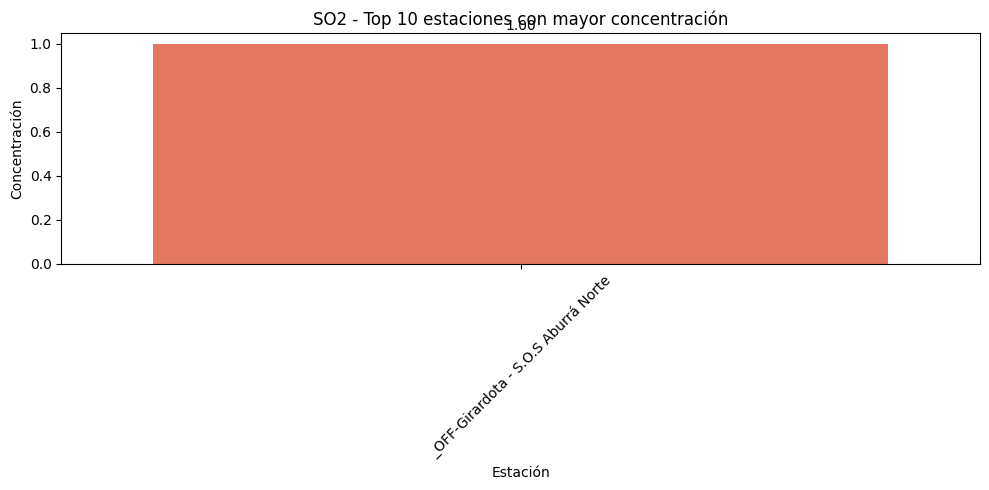

In [46]:
# Promedio por estación
top_estaciones = df.groupby('nombre')['valor'].mean().sort_values(ascending=False).head(10).reset_index()

# Paleta de colores (más alta concentración = más oscuro)
paleta = sns.color_palette("Reds", n_colors=len(top_estaciones))

# Gráfico
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=top_estaciones,
    x='nombre', y='valor',
    palette=paleta[::-1]
)

# Etiquetas
for i, val in enumerate(top_estaciones['valor']):
    ax.text(i, val + 0.05, f'{val:.2f}', ha='center', va='bottom')

plt.title(f'{contaminante_unico.upper()} - Top 10 estaciones con mayor concentración')
plt.ylabel('Concentración')
plt.xlabel('Estación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

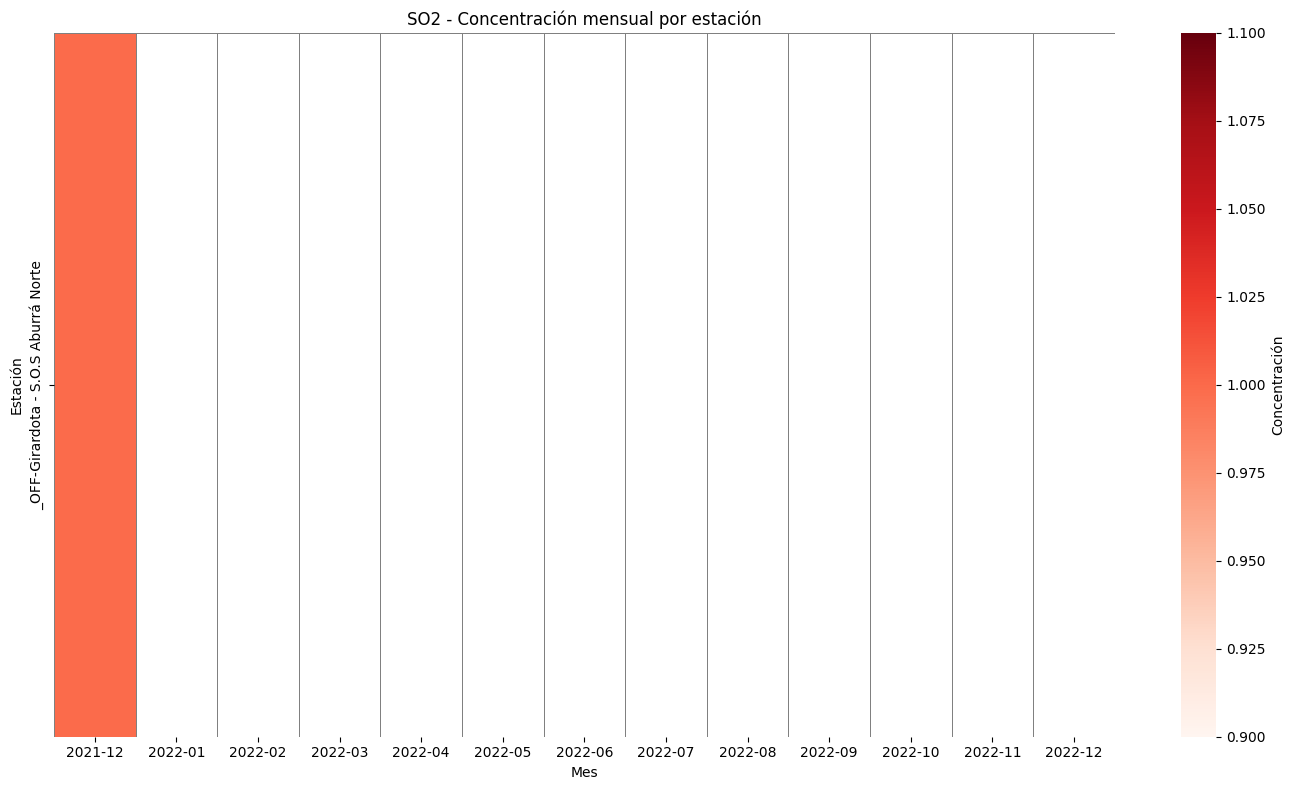

In [47]:
# Crear columna de mes
df['mes'] = df['fecha'].dt.to_period('M').astype(str)

# Agrupamos por estación y mes
pivot_df = df.groupby(['nombre', 'mes'])['valor'].mean().reset_index()

# Reorganizar en forma de matriz
pivot_table = pivot_df.pivot(index='nombre', columns='mes', values='valor')

# Crear heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap="Reds", linewidths=0.5, linecolor='gray', annot=False, fmt=".1f", cbar_kws={'label': 'Concentración'})
plt.title(f'{contaminante_unico.upper()} - Concentración mensual por estación')
plt.xlabel('Mes')
plt.ylabel('Estación')
plt.tight_layout()
plt.show()

In [48]:
import plotly.express as px

# Asegurar que el mes esté como string
df['mes'] = df['fecha'].dt.to_period("M").astype(str)

# Calcular promedio mensual por estación
mapa_mensual = df.groupby(['nombre', 'latitud', 'longitud', 'mes'])['valor'].mean().reset_index()

media_mensual_limpio = mapa_mensual.dropna(subset=['valor'])

# Crear mapa animado
fig = px.scatter_mapbox(
    media_mensual_limpio,
    lat="latitud", lon="longitud",
    color="valor",
    size="valor",
    animation_frame="mes",
    hover_name="nombre",
    color_continuous_scale="Reds",
    size_max=15,
    zoom=10,
    mapbox_style="carto-positron",
    title=f'{contaminante_unico.upper()} - Concentración mensual por estación'
)

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_21840\666634833.py:12: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

